In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [3]:
train_terms = pd.read_csv("Train/train_terms.tsv",sep="\t")
print(train_terms.shape)
train_terms.head()

(5363863, 3)


,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO


In [4]:
train_protein_ids = np.load('train_ids.npy')
print(train_protein_ids.shape)
print(train_protein_ids[:5])

train_embeddings = np.load('train_embeds.npy')

# Now lets convert embeddings numpy array(train_embeddings) into pandas dataframe.
column_num = train_embeddings.shape[1]
train_df = pd.DataFrame(train_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(train_df.shape)
train_df.head()

(142246,)
['P20536' 'O73864' 'O95231' 'A0A0B4J1F4' 'P54366']
(142246, 1024)


,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_1015,Column_1016,Column_1017,Column_1018,Column_1019,Column_1020,Column_1021,Column_1022,Column_1023,Column_1024
0,0.049488,-0.032935,0.032473,-0.033723,-0.059505,0.075936,-0.045860,-0.104476,-0.072112,0.038806,...,-0.046516,-0.028773,-0.021878,-0.097883,0.056475,0.080950,-0.020938,-0.043532,0.096463,0.073070
1,-0.044616,0.064925,-0.080263,-0.075338,-0.004731,0.025408,-0.024685,-0.016568,-0.038980,-0.033870,...,-0.040173,0.003925,0.006130,0.007362,-0.066848,0.106882,-0.030134,0.026724,0.027879,-0.048430
2,-0.020128,-0.049779,0.007894,-0.000829,-0.047737,0.086453,-0.038107,-0.036379,0.029611,0.045029,...,0.029388,0.008456,0.000697,0.013502,-0.005968,-0.011571,0.005704,-0.036103,0.007693,0.106234
3,-0.007515,0.060628,0.004045,0.027056,-0.021542,0.010380,-0.025064,-0.055834,0.068238,0.027764,...,0.020792,0.023307,0.009009,0.018211,0.020820,-0.031738,0.013279,-0.018357,0.008087,0.010917
4,0.013468,0.041516,0.018435,-0.035595,0.008770,0.018699,-0.015452,-0.038092,-0.038326,-0.012299,...,-0.044742,-0.025432,-0.060886,-0.026915,0.026342,0.017237,0.014731,-0.016861,-0.016272,0.037054


In [5]:
# corr = train_df.corr()
# means_of_correlations = abs(corr).mean()

# plt.hist(means_of_correlations, bins=100)
# plt.show()

# threshold = 0.12
# highly_correlated_cols = means_of_correlations[means_of_correlations > threshold]

# print('Number of highly correlated cols:', len(highly_correlated_cols))
# print('Column names:', highly_correlated_cols.index)


(31466,)


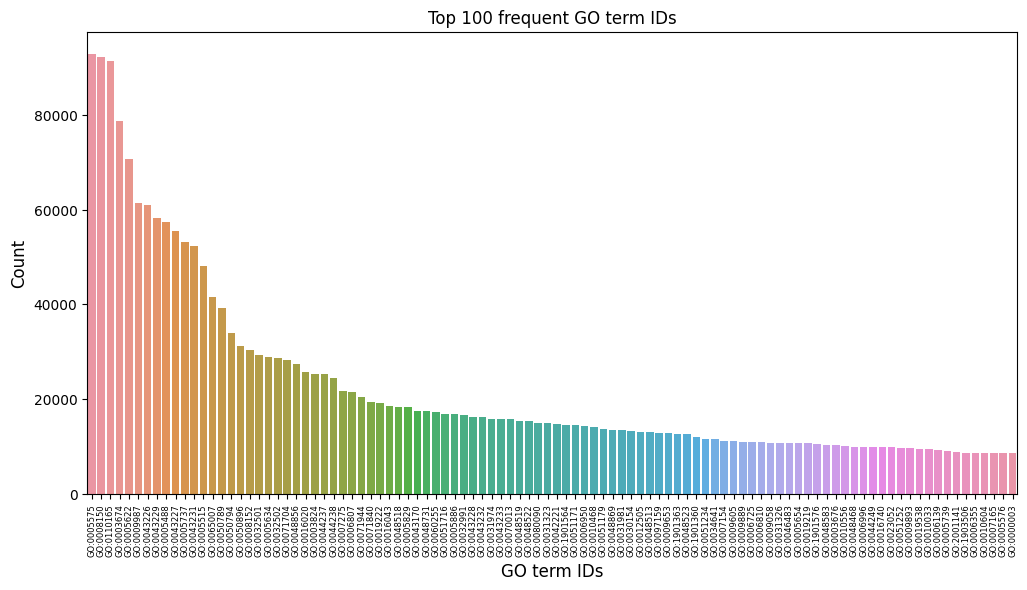

In [6]:
print(train_terms['term'].value_counts().shape)

# Select first 1500 values for plotting
plot_df = train_terms['term'].value_counts().iloc[:100]

figure, axis = plt.subplots(1, 1, figsize=(12, 6))

bp = sns.barplot(ax=axis, x=np.array(plot_df.index), y=plot_df.values)
bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 6)
axis.set_title('Top 100 frequent GO term IDs')
bp.set_xlabel("GO term IDs", fontsize = 12)
bp.set_ylabel("Count", fontsize = 12)
plt.show()

(3603814, 3)


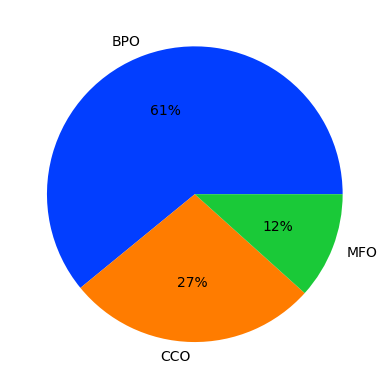

In [7]:
# Set the limit for label
num_of_labels = 500

# Take value counts in descending order and fetch first 1500 `GO term ID` as labels
labels = train_terms['term'].value_counts().index[:num_of_labels].tolist()

# Fetch the train_terms data for the relevant labels only
train_terms_updated = train_terms.loc[train_terms['term'].isin(labels)]
print(train_terms_updated.shape)

pie_df = train_terms_updated['aspect'].value_counts()
palette_color = sns.color_palette('bright')
plt.pie(pie_df.values, labels=np.array(pie_df.index), colors=palette_color, autopct='%.0f%%')
plt.show()

In [8]:
from tqdm import tqdm

# Create an empty dataframe of required size for storing the labels,
# i.e, train_size x num_of_labels (142246 x 1500)
train_size = train_protein_ids.shape[0] # len(X)
train_labels = np.zeros((train_size ,num_of_labels))

# Convert from numpy to pandas series for better handling
series_train_protein_ids = pd.Series(train_protein_ids)

# Loop through each label
for i in tqdm(range(num_of_labels)):
    # For each label, fetch the corresponding train_terms data
    n_train_terms = train_terms_updated[train_terms_updated['term'] ==  labels[i]]

    # Fetch all the unique EntryId aka proteins related to the current label(GO term ID)
    label_related_proteins = n_train_terms['EntryID'].unique()

    # In the series_train_protein_ids pandas series, if a protein is related
    # to the current label, then mark it as 1, else 0.
    # Replace the ith column of train_Y with with that pandas series.
    train_labels[:,i] =  series_train_protein_ids.isin(label_related_proteins).astype(float)

# Convert train_Y numpy into pandas dataframe
labels_df = pd.DataFrame(data = train_labels, columns = labels)
print(labels_df.shape)
labels_df.head()

100%|██████████| 500/500 [01:00<00:00,  8.24it/s]

(142246, 500)


,GO:0005575,GO:0008150,GO:0110165,GO:0003674,GO:0005622,GO:0009987,GO:0043226,GO:0043229,GO:0005488,GO:0043227,...,GO:0140657,GO:0044297,GO:0030659,GO:0051129,GO:0099568,GO:0044403,GO:0042803,GO:0016829,GO:0090596,GO:0051640
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [9]:
labels_df.head()

,GO:0005575,GO:0008150,GO:0110165,GO:0003674,GO:0005622,GO:0009987,GO:0043226,GO:0043229,GO:0005488,GO:0043227,...,GO:0140657,GO:0044297,GO:0030659,GO:0051129,GO:0099568,GO:0044403,GO:0042803,GO:0016829,GO:0090596,GO:0051640
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [10]:
labels_df.to_csv('labels_df.csv')

In [11]:
labels_df

,GO:0005575,GO:0008150,GO:0110165,GO:0003674,GO:0005622,GO:0009987,GO:0043226,GO:0043229,GO:0005488,GO:0043227,...,GO:0140657,GO:0044297,GO:0030659,GO:0051129,GO:0099568,GO:0044403,GO:0042803,GO:0016829,GO:0090596,GO:0051640
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142241,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142242,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142243,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142244,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# corr = train_df.corr()
# means_of_correlations = abs(corr).mean()
# plt.hist(means_of_correlations,bins=100)
# plt.show()
# highly_correlated_cols= np.where(means_of_correlations>0.12)
# print('number of bad cols:' ,len(highly_correlated_cols[0]))
# print('col numbers:',(highly_correlated_cols[0]+1))

# # Display the correlation matrix
# print("Correlation Matrix:")
# print(corr)


In [13]:
# PCA 1024 to 100:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(train_df)

# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

# Get the explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_

# Sort the features based on their importance (explained variance)
sorted_indices = np.argsort(explained_variance_ratio)[::-1]

# Select the top 100 features
top_100_indices = sorted_indices[:100]

# Drop the remaining features
selected_features = train_df.iloc[:, top_100_indices]

# Create a new DataFrame with the selected features
selected_df = pd.DataFrame(selected_features)

# Identify the dropped columns
dropped_columns = train_df.columns.difference(selected_df.columns)

print("Dropped columns:", dropped_columns)
print("selected columns:", selected_df)



Dropped columns: Index(['Column_1000', 'Column_1001', 'Column_1002', 'Column_1003',
       'Column_1004', 'Column_1005', 'Column_1006', 'Column_1007',
       'Column_1008', 'Column_1009',
       ...
       'Column_990', 'Column_991', 'Column_992', 'Column_993', 'Column_994',
       'Column_995', 'Column_996', 'Column_997', 'Column_998', 'Column_999'],
      dtype='object', length=924)
selected columns:         Column_1  Column_2  Column_3  Column_4  Column_5  Column_6  Column_7   
0       0.049488 -0.032935  0.032473 -0.033723 -0.059505  0.075936 -0.045860  \
1      -0.044616  0.064925 -0.080263 -0.075338 -0.004731  0.025408 -0.024685   
2      -0.020128 -0.049779  0.007894 -0.000829 -0.047737  0.086453 -0.038107   
3      -0.007515  0.060628  0.004045  0.027056 -0.021542  0.010380 -0.025064   
4       0.013468  0.041516  0.018435 -0.035595  0.008770  0.018699 -0.015452   
...          ...       ...       ...       ...       ...       ...       ...   
142241  0.032529  0.032490  0.0268

In [14]:
#PCA with threshold:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load your dataset or create a sample dataset
# Assuming you have a DataFrame 'data_df' with features

# Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(train_df)

# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

# Get the explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_

# Specify your threshold (e.g., 0.95) based on your logic and domain knowledge
threshold = 0.95

# Determine the number of components to retain based on the threshold
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
num_components = np.argmax(cumulative_explained_variance >= threshold) + 1

# Fit PCA with the selected number of components
pca_selected = PCA(n_components=num_components)
pca_result_selected = pca_selected.fit_transform(scaled_data)

# Transform the selected components back to the original space
selected_features = pca_selected.inverse_transform(pca_result_selected)

# Create a DataFrame with the selected features
selected_df = pd.DataFrame(data=selected_features, columns=train_df.columns)

# Identify the dropped columns
dropped_columns = train_df.columns.difference(selected_df.columns)

print("Number of components retained:", num_components)
print("Dropped columns:", dropped_columns)


Number of components retained: 448
Dropped columns: Index([], dtype='object')


In [16]:
#LDA:
#TODO check X and y
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Load your dataset or create a sample dataset
# Assuming you have a DataFrame 'data_df' with features and a target column 'target'

# Separate features and target
X = train_df
y = labels_df.columns()

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply LDA
lda = LinearDiscriminantAnalysis(n_components=None)  # You can set n_components to a specific number if needed
X_lda = lda.fit_transform(X_scaled, y)

# Print the explained variance ratio for each component
print("Explained Variance Ratio:", lda.explained_variance_ratio_)

# Select the top components based on explained variance or a fixed number
num_components_to_keep = 100  # Set the number of components you want to retain

# Use the top components for further analysis/classification
X_lda_selected = X_lda[:, :num_components_to_keep]


TypeError: 'Index' object is not callable